# Parameter Inference in Astronomy

Below we load some handy libraries for our tutorial and configure a bit to make plots prettier.

In [1]:
## Import packages
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

## Matplotlib settings
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 16
plt.rcParams['axes.grid'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['grid.alpha'] = 0.4
plt.rcParams['figure.figsize'] = (8, 8)

## 4. Mass-concentration relation of halos: an exercise

I have set up a new problem on dark-matter halos with data.
It's time for you to practice parameter constraints by yourself now!

### Context

Dark-matter halos are bound structures of matters due to gravitational attractions.
These structures can be very massive to induce significant gravitational lensing effects.

The mass profiles of halos are well-described by the Navarro-Frenk-White model,
in which the halo shapes can be described by only 2 parameters: the mass $M$ and the concentration $c$,
which we assume to be independent from cosmology.
From simulations, researchers suggest that despite a large scatter, $c$ seems to depend on $M$.
Thus, a _mass-concentration relation_ $c(M)$ is needed and this is what we are going to study here.

The data are contained in the ASCII file `data/halo_cat.dat`.
They are adapted from a [halo catalogue](http://www.benediktdiemer.com/data/halo-catalogs/) 
of the Erebos $N$-body simulations by Benedikt Diemer.

### Mass-concentration relation

The mass-concentration relation is usally written under the following form:

$$c(M,z) = \frac{A}{(1+z)^C}\bigg(\frac{M}{M_\mathrm{ref}}\bigg)^B,$$

where $z$ is the redshift, $M_\mathrm{ref}$ is a chosen reference mass, and $A$, $B$, and $C$ are parameters.
Here we are going to ignore the redshift dependence and set the reference mass to $10^{14} [M_\odot/h]$.
In this case, the $M$-$c$ relation can be written as:

$$\log c = \alpha (\log M -14) + \beta,$$

where $\alpha$ and $\beta$ are parameters. 
The equation above is a simple linear relation,
so the best-fit $\alpha$ and $\beta$ can easily be obtained from linear regression.
However, we want to obtain estimation errors on $\alpha$ and $\beta$ as well.
That's why we apply parameter inference here.

### Analysis guideline

Our objective is to constrain $\alpha$ and $\beta$ jointly.
We don't plan to do so object-by-object, but mass bin-by-mass bin.
The expected result is a corner plot similar to Question 3.9.

If you need them, here are some hints:
- Construct points of $(\log M, \log c)$ from the catalogue
- Determine the scatter of $\log c$ in each $\log M$ bin
- Think about what the observed vector, model vector, and covariance are. 
- Evaluate the Gaussian likelihood on a chosen grid
- Determine quantities required for credible intervals and contours
- Draw the constraints

**TODO: Obtain a corner plot for $\alpha$ and $\beta$ joint constraints**

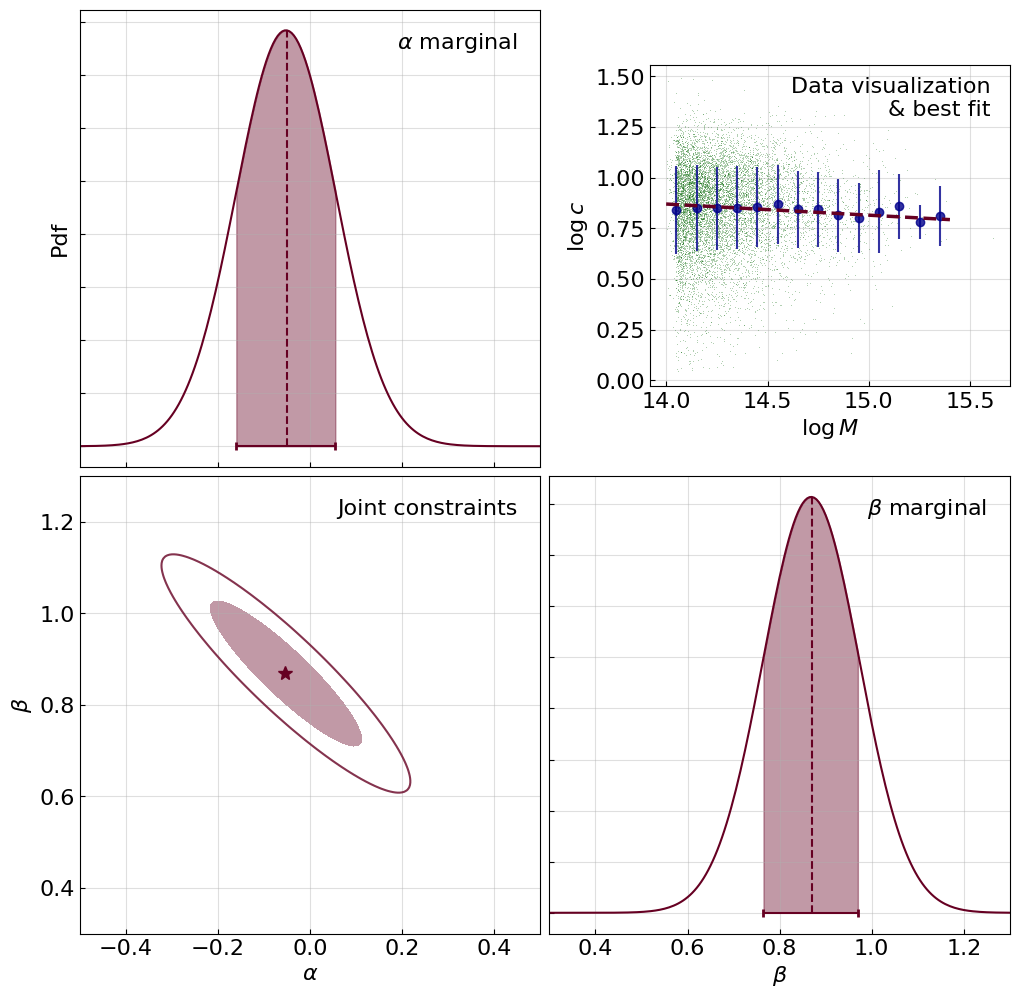

In [2]:
## TODO: Add your code here for joint constraints

## Load data
data = np.loadtxt('data/halo_cat.dat').T
M = data[0]
c = data[1]
log_M = np.log10(M)
log_c = np.log10(c)

## Define log M bins
bins = np.arange(14.0, 15.400001, 0.1)
lower = bins[:-1]
upper = bins[1:]

## Calculate mean(log c) and std(log c) in each bin
stock = []
for l, u in zip(lower, upper):
    index = (l <= log_M) * (log_M < u)
    log_c_selected = log_c[index]
    mean = np.mean(log_c_selected)
    std = np.std(log_c_selected, ddof=1)
    stock.append([0.5*(l+u), mean, std])
    
## After this operation, `stock` contains 3 columns,
## which are center of log M bins, mean(log c), and std(log c).
stock = np.array(stock).T
log_M_ctr = stock[0]
log_c_mean = stock[1]
log_c_std = stock[2]

## Define figure
fig = plt.figure(figsize=(12, 12))

## Go to top-right panel
ax2 = fig.add_subplot(2, 2, 2)

## Plot all halos
ax2.plot(log_M, log_c, ',', alpha=0.3, color='darkgreen')

## Plot the binned result
ax2.errorbar(log_M_ctr, log_c_mean, yerr=log_c_std, fmt='o', color='darkblue', alpha=0.8)

## Layout
ax2.set_aspect('equal')
ax2.set_xlabel(r'$\log M$')
ax2.set_ylabel(r'$\log c$')



## Build the inverse covariance
inv_cov = np.diag(1 / log_c_std**2)

## Define functions for model, dx, and chi^2
model = lambda alpha, beta: alpha*(log_M_ctr-14) + beta
dx = lambda alpha, beta: model(alpha, beta) - log_c_mean
chi_2 = lambda alpha, beta: dx(alpha, beta).dot(inv_cov).dot(dx(alpha, beta))

## Define the prior
alpha_arr = np.arange(-0.5, 0.500001, 0.005)
beta_arr = np.arange(0.3, 1.3000001, 0.005)

## Define the likelihood grid
like_grid = np.zeros((beta_arr.size, alpha_arr.size), dtype=float)

## Grid evaluation of likelihood
for j, beta in enumerate(beta_arr):
    for i, alpha in enumerate(alpha_arr):
        like_grid[j][i] = chi_2(alpha, beta)
        
## Convert chi^2 to likelihood
like_grid = np.exp(-0.5*like_grid)

## Calculate the maximum likelihood/posterior
index_like_max = like_grid.flatten().argmax()
index_like_max_1 = index_like_max % alpha_arr.size
index_like_max_2 = index_like_max // alpha_arr.size
alpha_best = alpha_arr[index_like_max_1]
beta_best = beta_arr[index_like_max_2]

## I love this color.
color = '#660022'

## Plot the best-fit parameters
ax2.plot(bins, alpha_best*(bins-14)+beta_best, '--', color=color, zorder=10, lw=2.5)



## Define `find_threshold`
def find_threshold(posterior, fraction):
    assert fraction >= 0 and fraction <= 1, '`target` has to be in [0, 1]'
    post_sum = posterior.sum()
    post = posterior.copy() / post_sum
    post = np.sort(post, kind='mergesort')
    post_cumsum = post.cumsum()
    boolean = post_cumsum >= 1 - fraction
    index = boolean.argmax()
    threshold = post[index]
    threshold *= post_sum
    return threshold

## Define 1 and 2 sigma fractions
fraction_1 = stats.norm.cdf(1) - stats.norm.cdf(-1)
fraction_2 = stats.norm.cdf(2) - stats.norm.cdf(-2)

## Calculate thresholds
th_1 = find_threshold(like_grid.flatten(), fraction_1)
th_2 = find_threshold(like_grid.flatten(), fraction_2)

## Go to bottom-left panel
ax3 = fig.add_subplot(2, 2, 3)

## Plot contours
ax3.contourf(alpha_arr, beta_arr, like_grid, levels=[th_1, float('inf')], 
             colors=[color], alpha=0.4)
ax3.contour(alpha_arr, beta_arr, like_grid, levels=[th_2], 
            colors=[color], linestyles=['-'], alpha=0.8)
ax3.plot(alpha_best, beta_best, '*', color=color, ms=10)

## Layouts
ax3.set_xlabel(r'$\alpha$')
ax3.set_ylabel(r'$\beta$')



## Calculate marginals
marg_alpha = like_grid.sum(axis=0)
marg_beta = like_grid.sum(axis=1)

## Define `find_edges`
def find_max_and_edges(posterior, threshold):
    index_max = posterior.argmax()
    boolean = posterior >= threshold
    index_l = boolean.argmax()
    index_u = boolean[::-1].argmax()
    index_u = boolean.size - 1 - index_u
    return index_l, index_max, index_u

## Find threshold, max, and edges for alpha
th_alpha = find_threshold(marg_alpha, fraction_1)
index_alpha_l, index_alpha_max, index_alpha_u= find_max_and_edges(marg_alpha, th_alpha)
lower_alpha = alpha_arr[index_alpha_l]
max_alpha = alpha_arr[index_alpha_max]
upper_alpha = alpha_arr[index_alpha_u]

## Go to the top-left panel
ax1 = fig.add_subplot(2, 2, 1)

## Plot the marginal and credible interval for alpha
ax1.plot(alpha_arr, marg_alpha, color=color)
ax1.fill_between(alpha_arr[index_alpha_l:index_alpha_u+1], marg_alpha[index_alpha_l:index_alpha_u+1], color=color, alpha=0.4)
ax1.errorbar(max_alpha, 0, xerr=[[max_alpha-lower_alpha], [upper_alpha-max_alpha]], fmt='', color=color, capsize=3, capthick=2)
ax1.plot([max_alpha, max_alpha], [0, marg_alpha[index_alpha_max]], '--', color=color)

## Layout
ax1.set_xlim(alpha_arr[0], alpha_arr[-1])
ax1.set_ylabel('Pdf')
ax1.set_xticklabels([]);
ax1.set_yticklabels([])



## Find threshold, max, and edges for beta
th_beta = find_threshold(marg_beta, fraction_1)
index_beta_l, index_beta_max, index_beta_u = find_max_and_edges(marg_beta, th_beta)
lower_beta = beta_arr[index_beta_l]
max_beta = beta_arr[index_beta_max]
upper_beta = beta_arr[index_beta_u]

## Go to the bottom-right panel
ax4 = fig.add_subplot(2, 2, 4)

## Plot the marginal and credible interval for beta
ax4.plot(beta_arr, marg_beta, color=color)
ax4.fill_between(beta_arr[index_beta_l:index_beta_u+1], marg_beta[index_beta_l:index_beta_u+1], color=color, alpha=0.4)
ax4.errorbar(max_beta, 0, xerr=[[max_beta-lower_beta], [upper_beta-max_beta]], fmt='', color=color, capsize=3, capthick=2)
ax4.plot([max_beta, max_beta], [0, marg_beta[index_beta_max]], '--', color=color)

## Layout
ax4.set_xlim(beta_arr[0], beta_arr[-1])
ax4.set_xlabel(r'$\beta$')
ax4.set_yticklabels([]);

## Texts
ax1.annotate(r'$\alpha$ marginal', (0.45, marg_alpha[index_alpha_max]), ha='right', va='top')
ax2.annotate('Data visualization\n& best fit', (15.6, 1.5), ha='right', va='top')
ax3.annotate('Joint constraints', (0.45, 1.25), ha='right', va='top')
ax4.annotate(r'$\beta$ marginal', (1.25, marg_beta[index_beta_max]), ha='right', va='top')

## Final layout
fig.subplots_adjust(wspace=0.02, hspace=0.02)
ax2.set_position([0.6, 0.55, 0.3, 0.3]);

## End of TODO